In [10]:
import os
from fastai import *
from fastcore.all import *
from fastai.vision.all import *
import pandas as pd
from PIL import Image
import re
from pathlib import Path
import numpy as np
np.random.seed(42)

In [8]:
PHOTOS_TRAIN_PATH = './raw_photos' # This is the name of the training set folder

In [ ]:
photos_train_path = Path(PHOTOS_TRAIN_PATH)
photos_train_path

In [13]:
def create_dataset_from_raw_data(data_set , data_location):
    """ data_set is a path to csv path generated by reddit_bf_scraping.py (i.e., "raw_comments_bf.csv" after preprocessing). """
    output_df = pd.DataFrame(columns=["id",
                                      "bf_est",
                                      "image_path"])
    i = 0
    df = pd.read_csv(data_set)
    for j in range(len(df)):
        # several images can be attributed to a single id (i.e., images of the same user)
        id_images = [f for f in os.listdir(data_location) if re.match(fr'image_{df.iloc[j]["id"]}.*', f)]
        for image_name in id_images:
            output_df.loc[i] = [df.iloc[j]["id"], df.iloc[j]['bf_est'], data_location/image_name]
            i += 1
    output_df.to_csv('data_set.csv', index= False)

In [ ]:
def get_x(df):
  return Path(df['image_path'])

def get_y(df):
  return df['bf_est']

def train_valid_splitter(df):
  # We create a non trivial splitter so we wont need to deal with data leakage between train and valid sets (i.e. a certain user might have
  # more then one photo)
  unique_ids = df['id'].unique()
  np.random.shuffle(unique_ids)
  num_unique_in_train = int(np.ceil(len(unique_ids) * 0.8))
  train_ids = unique_ids[:num_unique_in_train]
  train = df.index[df['id'].isin(train_ids)].tolist()
  valid = df.index[~df['id'].isin(train_ids)].tolist()
  return test, valid

In [ ]:
create_dataset_from_raw_data('data_for_DL.csv', photos_train_path)

In [ ]:
df = pd.read_csv('data_set.csv')
d_block = DataBlock(blocks=(ImageBlock, RegressionBlock),
                    splitter = train_valid_splitter,
                    get_x = get_x,
                    get_y = get_y,
                    item_tfms=[Resize(192, method='squish')],
                    batch_tfms=aug_transforms())
dls = d_block.dataloaders(df)

In [ ]:
#Training a Model
learn = vision_learner(dls, resnet34, y_range=(2,45))

SuggestedLRs(valley=0.004365158267319202)

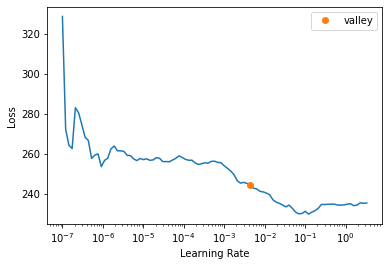

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(30, lr)

epoch,train_loss,valid_loss,time
0,233.271301,230.985367,03:21


epoch,train_loss,valid_loss,time
0,151.785721,144.166901,03:21
1,126.522842,88.111603,03:23
2,103.335289,58.007004,03:20
3,79.723846,35.634762,03:22
4,59.770061,25.969162,03:20
5,46.408661,32.795773,03:21
6,37.871155,39.878986,03:24
7,31.434708,30.115423,03:20
8,26.249168,44.713211,03:28
9,22.089558,24.596237,03:17


In [ ]:
learn.export('bf_model_resnet34_epoch_30_lr_1e-2.pkl')